# <i class="fas fa-book fa-fw"></i> Assessing Performance

```{margin}
1\. A quick review of these statistical models:

1. Linear Regression Model $y_i = w_0 + w_1x_i + \varepsilon_i$
2. Polynomial Regression Model $y_i = w_0 + w_1x_i + w_2x_i^2$
    $\ \ \ \ + ... + w_px_i^p + \varepsilon_i$
3. General Regression Model $y_i = \sum_{j=0}^D w_ih_j(x_i) + \varepsilon_i$
```

In the last chapter, we introduced the general machine learning
pipeline in the context of linear regression. We learned about the
regression model, using gradient descent to learn a predictor that
minimizes our quality metric. We also introduced the important concept
of the features used by the model, where you can transform your input
data to learn more complex relationships (e.g. polynomial regression)<sup>1</sup>.

When we introduced this flexibility of learning more complex relationship in the specific context of polynomial regression, we introduced a subtle challenge that we needed to identify a solution to: If we are able to train a regression model with a polynomial of any degree ppp, how do we know which one to use? Remember, we only have access to the given data, not the true function.

```{video} ../../_static/regression/assessing_performance/manim_animations/simple_poly_regression_anim.mp4
```

$\ $

```{margin}
2\. Example: There is strong empirical evidence that shows there is a linear relationship between femur length and your height.
```

If you have prior information, or a domain expert you're working with gives you information about the model you should use, you should start with that. For example, if you have evidence to support that the underlying function is, say linear<sup>2</sup>, then you should start by using $p = 1$. Remember models are always assumptions about how the world works, so in some contexts, you might want to be skeptical and try other options.

If you don't have as much expertise in the context your working in, you might need to identify what the degree should be. A fundamental question to choosing the right $p$ is discussing how to **assess the performance** of a predictor so that you can compare these various models.

Given what we've discussed so far, our first instinct might be to us the quality metric (e.g., MSE) on the data the predictor was trained from. Given the predictors (colored curves) in the animation above, which one will have the lowest MSE on the training dataset (the black dots)?<sup>3</sup>

In [1]:
questions = [
    {
        "question": r"""Which predictor in the animation above has the lowest MSE on the dataset shown?""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "$p = 1$",
                "correct": False
            },
            {
                "answer": "$p = 3$",
                "correct": False
            },
            {
                "answer": "$p = 5$",
                "correct": False
            },
            {
                "answer": "$p = 7$",
                "correct": False
            },
            {
                "answer": "$p = 9$",
                "correct": True,
                "feedback": r"""
                    With a higher degree polynomial, it is allowed to "wiggle" up and down more. If you keep letting the degree grow, it will eventually be able to be complex enough so that the curve passes perfectly through every point. In other words, a sufficiently high degree polynomial might be able to get an MSE of 0. So following that approach would lead to use selecting the model with the highest degree $p$ every time!
                """
            }
        ]
    },
]

from jupyterquiz import display_quiz
display_quiz(questions, shuffle_answers=False)

<IPython.core.display.Javascript object>

```{margin}
3\. Like Redfin/Zillow trying to predict the price of a house on a new listing.
```

So using the logic from this explanation, if we chose the right polynomial degree based on lowest MSE on the data we trained on, we would always choose the highest degree polynomial possible. This happens because there is a mismatch in how we are assessing our predictor and the goal we set out to accomplish originally. Remember, in many contexts the goal of training a predictor is to use it out in the wild on new data as it comes in<sup>3</sup>. If we choose the model that minimizes MSE of the data it learned from, we are just rewarding models that have sufficient complexity to *memorize* the dataset, and have no guarantee on how well it will generalize.

An analogy: Suppose you studied a specific practice exam for a few hours and afterwards, you were able to answer 100% of the questions correctly after taking it multiple times. Would you expect to get 100% on the real exam based on that practice exam alone? Not necessarily! It's entirely possible that you could have just memorized the specific answers on that one practice exam, rather than learning general concepts that enable you to answer related questions that you haven't seen before.

The key idea here is that assessing your predictor on data it encountered while training will likely *overestimate its true performance on future, unseen data*. The predictor is able to shape its knowledge around these specific examplea you showed it while training, so it's more likely to get those ones correct. This is exactly the same as it being easier for you to answer a question on the test that also showed up on the practice test.

So if we care about future performance, how might we go about assessing the predictor? Instead of only considering the error metric like the RSS on the training dataset, we will also consider the **true error** of our predictor. The true error tries to quantify how severe the errors are that we might expect to see in the future.

### A brief seque into theory-land

In order to understand what we intend to capture in a notion of "true error", we have to highlight some additional statistical assumptions we are making. For this discussion, we will stick with the housing example, but these ideas apply more broadly to other contexts.

Not all house square footages are equally likely to show up in the wild. There are probably no homes that have fewer than 10 square feet (although some New York City apartments might feel like an exception). We might expect that there is a distribution over the possible square footages, indicating that some square footages are more likely than others.

```{margin}
4\. This is why our model always includes a $+ \varepsilon_i$ in the relationship between features/output. We are allowing some variance in how we expect the price to behave at a particualr square footage.
```

On top of that, for any particular square footage, we might expect to see a range of possible prices for the house of that size<sup>4</sup>. It's entirely expected that each square footage has its own distribution of prices; if this were not the case, we would predict the same price for every house of the same size, regardless of other features such as their location. For example, we would expect the prices for larger homes to trend to be more expensive. This forms what statisticians call a "join distribution", where there is a distribution over the combinations of square footage and price.

We can visualize this joint distribution with a joint plot that shows the density around certain pairings of square footages and prices. This is kind of looking at a topographical map showing some regions of equal density (very likely to have a price at that square footage and that price) and showing where the "peak" of the mountain is. Also it is helpful to look at the distributions on the side called the *marginal distributions*. The graph at the top looks at the distribution of all square footages, ignoring price, and the graph on the right shows the distribution of all prices, ignoring square footage; alternatively phrased as "projecting" the data onto a single axis. Note that the data below is purely synthetic and has no tie to real-world house prices.

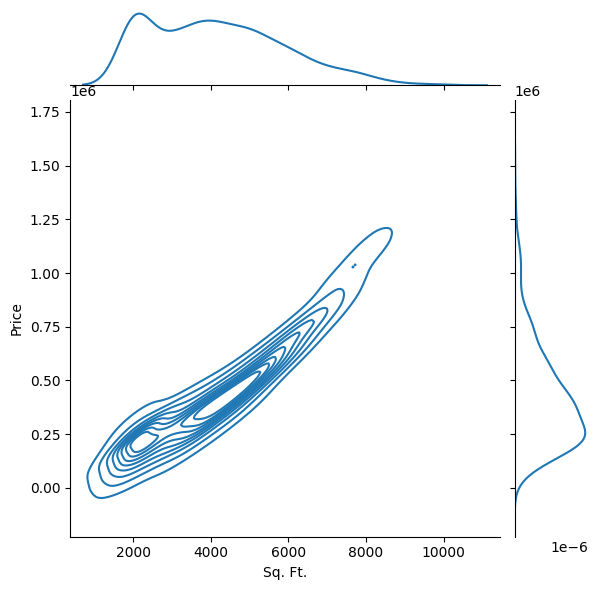

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

NUM_POINTS = 1000
SEED = 43
X_SCALE = 2000
Y_NOISE_SCALE = 60000

def f(x):
    return 100 + (0.5 * x + 1.5 * x * x) / 100

np.random.seed(SEED)
x = np.random.randn(NUM_POINTS) + 2
x = np.clip(x, 1, 20)
x = X_SCALE * x
y = f(x) + np.random.randn(NUM_POINTS) * Y_NOISE_SCALE
y = y + abs(y.min()) + 10000
df = pd.DataFrame({"Sq. Ft.": x, "Price": y})

_ = sns.jointplot(data = df, x = "Sq. Ft.", y = "Price", kind="kde")

So in a notion of true error, we are looking to capture making sure our model is right as much as possible on example it is likely to see. We might say that it is less important to be accurate on very large, but very cheap houses since the underlying distribution of data we will see in the future doesn't make that combination likely. Instead, we are looking to measure how wrong our model is "in expectation" across all possible size/price points we could see.

```{margin}
5\. Our MSE from earlier is like a loss function, but for many points instead of just one. The analogue here would be squared error for a singleinput/output $L(y, \hat{f}(x)) = \left(y - \hat{f}(x)\right)^2$
```

This results in a notion we will call a **loss function $L\left(y, \hat{f}(x)\right)$**. A loss function is a generalization of our concept of MSE we discussed before. The loss function is a function that takes the true outcome and the prediction made by our predictor, and outputs a value to quantify the error made<sup>5</sup>. This generalization allows us to consider a broader class of loss function other than just MSE.

With these ideas, we can now define the true error as the expected loss we would see over all possible $(x, y)$ pairs from the possible inputs ($X$) and possible outputs ($Y$). This tries to capture how wrong our model will be "on average" over all possible inputs/outputs we can see in the future. The true error is defined as:

$$error_{true}(\hat{f}) = \mathbb{E}_{XY}\left[L\left(y, \hat{f}(x)\right)\right]$$

This notation should be read exactly as our last paragraph states. It's an expected value of the loss incurred over all $(x, y)$ pairs, weighted by how likely that $(x, y)$ pair is likely to appear.

```{margin}
6\. 📝 Notation: We use $x \in X$ to say some element $x$ in a set of possible elements $X$. Then, the sum $\sum_{x \in X}g(x)$ is the sum of values "looping" over every possible element in $X$.
```

If the inputs and outputs take on discrete values, we can write the $p(x,y)$ to mean the probability of seeing the pair $(x, y)$. We can write the idea of the average loss incurred weighted by the probability with the formula<sup>6</sup>:

$$\mathbb{E}_{XY}\left[L\left(y, \hat{f}(x)\right)\right] = \sum_{x \in X}\sum_{y \in Y} L(y, \hat{f}(x))\cdot p(x, y)$$

This definition should be reminiscent of a formula for an expectation (since that is what it is computing), with a few modifications. Now, there is the added complexity of dealing with the $(x, y)$ pairs which requires the nested sum. If this sum is large, that means "on average", the model incurs high loss (i.e. has lots of error).

The details of the specific notation is not the main point here. It's important to get the intuition behind what this value is trying to compute. So with that in mind, our task of selecting the model that generalizes best, is exactly the task of finding the model with the lowest true error.

Unfortunately in most real-life circumstances, it's not even possible to compute this true error! You might not know the  exact distributions of the houses or the distribution of prices conditioned on a particular house size. Since we don't know these distributions for a fact, there is no way we can exactly compute this expectation. Without access to all future data, it's essentially impossible to compute this true error exactly. However, we have hope to approximate it using well-defined practices.

### Back to practice

A very common technique in machine learning suggests that if you aren't able to exactly compute something, you can try to estimate it using data you have. That's what we will do here. But note that we can't use the data we trained on, since as we discussed, it would lead to us favoring more complex models since they can minimize training error with sufficient complexity. The idea then is to hide part of our dataset from our ML algorithm and use that hidden data as a *proxy* for "all future data" after the predictor is trained.

The most common way to accomplish this is to split your dataset into a **training set** and a **test set**.

* The training set is used by the ML algorithm to train the predictor.
* The test set is used the estimate the performance of how we expect the predictor to do on future data.

```{margin}
7\. 📝 *Notation*: $Test$ is our test dataset.

The notation $|S|$ denotes the number of elements in a set $S$. So $|Test|$ is the number of test datapoints.

We use a new notation for $\hat{f}$ to signify that it is the predictor defined by our estimates for the coefficients $\hat{w}$ by saying that $\hat{f}(x) = f_{\hat{w}}(x)$. Just two notations for the same thing, but the second is more explicit in what is estimated!
```

So even though the value we really care about is the true error, we will use this error computed from the test set as a stand-in for that value. We call the error made by the model on the test set the **test error**, which we can compute. In the case of regression using RSS as the loss function, the test error is defined as<sup>7</sup>:

$$MSE_{test}(\hat{w}) = \frac{1}{|Test|}\sum_{x_i \in Test} \left(y_i - f_{\hat{w}}(x_i)\right)^2$$

More generally, a common definition of the test error is the average loss for whichever loss function $L$ you are using:

$$error_{test}(\hat{f}) = \frac{1}{|Test|}\sum_{x_i \in Test} L(y, \hat{f}(x))$$

Our hope is that by using a large enough test set, we can reasonable approximate the true error. So how big of a test set is big enough?

Well in some sense, you want as big of a test set as possible since the more examples in your test set, the better estimate of the true error you will get. You can think of the extreme case where your test set contains all possible input/outputs you could ever gather, in which case you will exactly be able to compute the true error.

However, because you only have finite data available, by making your test set larger you will need to make your training set smaller. This can cause problems since we want as much training data possible to give us the best possible estimate of the true function. Remember, with  more training data we can have more confidence in a trend rather than it just being noise from a few examples.

<!-- TODO Make professional diagram -->

```{image} ../../_static/regression/assessing_performance/more_vs_less_training_data.png
:alt: Comparing a graph with two data points vs multiple data points. We feel more confident in a trend with more data
:class: bg-primary mb-1
:align: center
```

In practice, people generally use a ratio of 80% train and 20% test or 90% train and 10% test, but this really depends on your context and how much data you have! Two very important points about this test set:

```{margin}
8\. The one notable exception is when working with time-series data (e.g., stock market data). Since you are trying to predict the future, it makes sense for your test set to always be data in the future with respect to your training data. So with ML on time-series is the exception where you normally sort all of your data by time, and then make the test set the most-recent set of data so you can train on the past to predict the future. Almost every other context splitting randomly is correct.
```

1. When splitting a train/test set, you should usually do so randomly. If you selected the last 20% of the data as a test set you could potentially introduce biases in the test set. Imagine your data was sorted by square footage from smallest to largest. If you selected the last 20% of the rows as a test set, your test set would be entirely larger houses than the ones you trained on. This is not ideal since we wanted the test set to be a stand in for "all future data", which is not entirely large houses<sup>8</sup>.

2. Once you have put data in your test set, you must **never** train your predictor using those examples. You have to guard those test examples away from the ML algorithm with your life! If you fail to keep them separate and you accidentally train your predictor on the test set, you will no longer have a good estimate of the true error!

To make this more concrete, we include a very common sequence of steps used with `scikit-learn` to split our data into a training and test set, train on the training set, and evaluate on the test set. We start by splitting

In [3]:
from sklearn.datasets import load_diabetes   # For loading an example dataset
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load in dataset
features, labels = load_diabetes(return_X_y=True, as_frame=True)

# Breaks the data into 80% train and 20% test
features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.2)

# Print the number of training examples and the number of testing examples
print(f"Num Train: {len(features_train)}")
print(f"Num Test:  {len(features_test)}")

# Train our model
model = LinearRegression()
model.fit(features_train, labels_train)

# Evaluate the model to see its train and test performance.
# We care about test performance to estimate future performance
predictions_train = model.predict(features_train)
error_train = mean_squared_error(labels_train, predictions_train)
predictions_test = model.predict(features_test)
error_test = mean_squared_error(labels_test, predictions_test)

print(f"Training Error: {error_train}")
print(f"Test Error:     {error_test}")

Num Train: 353
Num Test:  89
Training Error: 2882.245688259254
Test Error:     2861.4857604408753


Note from this example output, we see the testing error is *lower* than the training error. This is possible, but unexpected in practice. As we will talk about in detail later in the following sections, this is a sign that our model might be  *underfit* (i.e., not complex enough to learn any reasonable relationship between the features and labels). More on this as you read on!

## Explaining Error

```{margin}
9\. We will not touch on more rigorous definitions of what complexity mean here such as *VC Dimension*. See [Understanding Machine Learning](https://www.amazon.com/Understanding-Machine-Learning-Theory-Algorithms/dp/1107057132) for an excellent introduction to learning theory.
```

In this section, let's explore the relationship between a model's complexity (e.g., its degree $p$) and its various types of error. By complexity of the model, we have a hand-wavy notion of the learned predictor's ability to learn more complicated relationships in the data (like a high degree polynomial); so in our regression example, a simple model is one like a line while a complex model is a high degree polynomial<sup>9</sup>.

The animation below shows the calculation of the *training error* as we increase the degree of the polynomial $p$. We draw a small number of points in the animation and then extrapolate the learning curve for all complexities in between. As we increase the complexity, the model has more and more capacity to perfectly match the data, so as we might expect, the training error would decrease.

```{video} ../../_static/regression/assessing_performance/manim_animations/poly_regression_train_error_anim.mp4
```

$\ $

```{margin}
10\. We will mention what happens to test error in a bit
```

Now consider what happens to the *true error*<sup>10</sup> as we change this complexity. Remember, we can't compute the true error in most contexts, but it's still useful to think about.

```{video} ../../_static/regression/assessing_performance/manim_animations/poly_regression_true_error_anim.mp4
```

$\ $

```{margin}
11\. This is assuming our training set is representative of the population. Usually, an assumption we have to make for the idea of using ML in the first place.
```

At first, when the model is too simple, the true error is higher. Suppose the simple model you tried at first, was a linear function but the true function was a quadratic. This linear predictor will accrue true error since it is incapable of learning the curve-like pattern, no matter how much training data it had. As the complexity of the model approaches the complexity of the true function, we expect the true error to go down<sup>11</sup>.

As the complexity continues to increase, we see the true error go up again. Think to the curve learned from the high-degree polynomial. Because it is capable of hitting the training points perfectly, the areas in-between get these wild wiggles in the learned predictor. These in-between areas are a source of error since the learned predictor doesn't match the true function. In the next section, we explain a more formal way of articulating these sources of error.

The animation below shows the same learning curves but on the same axes. The same patterns we saw before are present. One addition is the test error being drawn over the true error. We assume, with a large enough test set, that the test error is a good estimate of the true error so they should be close, but not necessarily the same.



```{margin}
12\. 📝 Notation: A $*$ denoting a variable usually means "optimal".
```

```{margin}
13\. Spoiler: **Never use the test error to select which complexity model you should use.**
```

The model with the lowest true error is the optimal model, which we notate<sup>12</sup> as $p^*$.  Unfortunately, we normally don't have access to the true error, which poses a challenge for selecting the optimal model. You might think that we can use the test error to choose the best model since it's estimating the true error. While that does seem reasonable, we will show later in this chapter why that won't work out<sup>13</sup>.

We generally have special terms to identify the performance of a model: **overfitting** and **underfitting**. We will give a more formal definition of overfitting below, but as a general intuition, models less complex than $p^*$ tend to underfit while models more complex than $p^*$ tend to overfit.

```{video} ../../_static/regression/assessing_performance/manim_animations/train_test_anim.mp4
```
$\ $

**Overfitting** happens when your model matches too closely to the noise in the training data rather than learning the generalized patterns. This happens, in our regression example, when a polynomial has a degree too high that allows it to memorize the data.

The formal definition of overfitting says a predictor $\hat{f}$ is overfit if there exists another predictor $f'$ that has the following properties:

* $error_{true}(f') < error_{true}(\hat{f})$
* $error_{train}(f') > error_{train}(\hat{f})$

In English, this says a model is overfit if there is another model that has higher training error, but lower true error. This means that the model you are using is too specific the training data you have: hence the term "over fit".

You can imagine the definition of underfit is similar, but the reverse. In English, an underfit model is one that is not complex enough to fit the the trend in the data (e.g., a linear model trying to fit data that comes from a quadratic function).
​
## Bias-Variance Tradeoff

So for many models, there is essentially a knob we can tune to balance the complexity between underfitting and overfitting. For our polynomial regression, it is the degree of the polynomial $p$. As you make the model more complex, it is easier to overfit. As you make the model less complex, it is harder to overfit and more likely to underfit. In the next section, we will talk about how to tune this knob so it is "just right", but first we will introduce some terms to describe why overfitting and underfitting happen.

```{margin}
14\. *The Signal and the Noise: Why So Many Predictions Fail, but Some Don't* - Nate Silver, 2012
```

Whenever we are using machine learning to model the world, we need to balance the signal and the noise that are present in our data<sup>14</sup>. It's impossible to tell from a single data point what parts of it result from the underlying model and what are contributed by noise. Whenever we are learning, we need to balance trying to fit to the data we are training on with the idea that we don't want to overfit to the specific noise patterns in this one dataset. In the regression model, we can decompose our true error into three components: **bias**, **variance**, and **irreducible noise**.

```{margin}
15\. For example, if I gave you a dataset of 100 coin flips from a fair coin, it's just as likely to see a dataset of 52 heads and 48 tails as it is to see a dataset with 48 heads and 52 tails; both are drawn from the same underlying distribution, but slight differences are expected to happen from chance.
```

Before defining these terms, we should highlight a specific assumption we have been making. We have been assuming the training dataset is a random sample from some underlying population distribution. Since it is a random sample, you could imagine it is just as likely that we would receive another dataset drawn from the same distribution that will look slightly different<sup>15</sup>.

```{margin}
16\. 📝 Notation: We use the $\bar{x}$ notation to mean average.
```

When thinking about machine learning, we are thinking that the data is generated from a process following the model we assume. So for the regression model, we assume that for each $x_i$ in our dataset, its corresponding $y_i = f(x_i) + \varepsilon_i$ for some unknown $f$. So since there is randomness not only in which inputs we receive, but in their associated output, we will expect to learn different predictors if we trained on different datasets drawn from the same distribution. We can think about what is the "average predictor" if we drew a bunch of different training sets, trained a predictor from each one, and averaged the results. The animation below shows this process and what this average predictor $\bar{f_{\hat{w}}}(x)$ looks like<sup>16</sup>.

```{video} ../../_static/regression/assessing_performance/manim_animations/avg_deg_1_anim.mp4
```

### Bias
```{margin}
17\. This does not necessarily line up with our every-day use of the word bias (e.g., discriminatory actions/views against certain groups). While it is crucial to avoid that type of bias in our models, this is not what the statistical notion of the term "bias" necessarily means. We will talk about our every-day notion of bias in the Fairness in ML chapter.
```

The **bias** of a model comes from it being too simple (or a mismatch with reality) that it fails to fit the signal in the data<sup>17</sup>.  In some sense, this signifies a fundamental limitation of the model we are using to fail to fit the underlying phenomena. The bias tries to measure how much the average predictor we will expect $\overline{f_{\hat{w}}}(x)$ differs from the true function $f$.

Mathematically we write this as the following. This definition is tries to capture how much this average predictor differs over the true function. The expectation is taken over the possible inputs you could receive (i.e. weighted to care more about inputs that you are more likely to see).

$$\text{Bias:}\ \ \mathbb{E}\left[\left|f(x) - \overline{f_{\hat{w}}}(x)\right|\right]$$

```{image} ../../_static/regression/assessing_performance/manim_animations/bias_deg_1_anim.png
:width: 100%
```

Low complexity (simple) models tend to have high bias which is why the tend to have higher true error if they are too simple.

### Variance

A model that is too complex for the task at hand has the potential to overfit to the noise in the data. The flexibility the complex model allows the model to potentially memorize rather than generalize. This error that comes from fitting to noise is attributed as **variance** of the model.

For our very complex model, a slightly different dataset will lead to a wildly different predictor since the function wiggles a lot between the points. The differences we see in the predictors learned on slightly different datasets is another sign of error. These differences account for fitting to specific artifacts in the one training set we learned on.

Mathematically we write the variance as the following. It tries to capture how much we expect any particular fit on a dataset to differ from the average. If this value is high, it means that we will expect to learn wildly different functions from dataset to dataset (even if they are relatively similar). If this value is low, it means that on each dataset, we learned about the same function (close to the average $\overline{f_{\hat{w}}}(x)$. The expectation here is over all possible datasets you could receive as training data.

$$\text{Variance:}\ \ \mathbb{E}\left[\left(\overline{f_{\hat{w}}}(x) - f_{\hat{w}}(x)\right)^2\right]$$

```{video} ../../_static/regression/assessing_performance/manim_animations/var_deg_8_anim.mp4
```

High complexity models tend to have high variance. Or in other words, we call models that have high variance "complex" to describe that behavior.

It turns out that bias and variance live on this complexity spectrum: decreasing one of bias/variance tends to increase the other.

* Simple models tend to have **high bias and low variance**
* Complex models tend to have **low bias and high variance**

```{margin}
18\. Don't worry about the squared business in the equation, just the idea that we can decompose the error.
```

In fact, in the case of measuring squared error with regression, you can exactly decompose the true error into contributions from bias and variance<sup>18</sup>. The noise in this equation corresponds to the distribution of the $\varepsilon$: if there is lots of underlying noise, there isn't much we can do about making a good predictor.

$$Error = Bias^2 + Variance + Noise$$

```{margin}
19\. Notice this graph has some of the common things we mentioned earlier about the tendency of low vs high complexity models and their bias/variance.
```

The following animation shows how the bias and variance change with model complexity, and how those two with noise (which is independent of model complexity) add up to the true error curve we saw earlier<sup>19</sup>.

```{video} ../../_static/regression/assessing_performance/manim_animations/bias_var_tradeoff_anim.mp4
```

One subtle point we have been leaving out is the discussion of the amount of data we have to train on in the first place. All of the earlier descriptions of "high complexity" or "low complexity" are in respect to how much data you have available to train on. In reality, the model's complexity is relative to how much data you have. For example, it's really easy for a 20 degree polynomial to overfit to 2 data points, but very difficult for it to overfit to 2 billion data points (it doesn't have the capacity to wiggle 2 billion times).

You can imagine thinking about what happens to our training and true error as we increase the amount of data we have in our training set. If we consider some fixed model complexity (e.g., a 20 degree polynomial), we can consider how the training/true error change as a function of the training set size. With a very small training set, a sufficiently complex model has the ability to overfit; thus leading to low training error and high true error. As we increase the training set size, a model of the same complexity is less able to overfit with more and more training points.


```{image} ../../_static/regression/assessing_performance/error_by_training_size.png
:width: 100%
```

```{margin}
20\. Remember our example of 20-degree polynomial's complexity is relative to how much data you have.
```

The training error starts out small when it is easy for the model to overfit to a small training set. When the training set is small and the model can overfit, we expect to have a higher true error (because it is overfitting). As you increase the training set size, it becomes harder and harder for a fixed-complexity model to overfit once the amount of data exceeds its flexibility<sup>20</sup>. This why we see the training error *increase* as you tend to have more training data. Conversely, since the model struggles to overfit with a large dataset, you see the true error decrease because the variance is actually going down: with a very large dataset, you learn approximately the same function each time.

```{margin}
21\. Using a linear model when the true function is, say, a cubic function
```

In the limit, when you have infinite training data, you would expect these curves to meet. This is because having every possible input/output means your training error is just computing the true error! Notice, they don't converge to 0. There is a floor they converge to based on the bias and noise of the model. Irreducible noise will never go away. If you are using a model with high bias<sup>21</sup> then, no matter how much training data you have, you will not be able to learn a sufficiently complex function so you will always have some non-zero error.

## How to Choose Model Complexity?

So we introduced this idea of training error and true error (and how we approximate it with test error), and where that error can manifest as overfitting or underfitting from the contributions of the model's bias and variance. Now that we understand that model complexity can impact the performance of the model, how do we actually go about picking the right complexity if we don't have access to this true error?

**Suggestion 1:** What about choosing the model with the lowest training error? Hopefully from our discussion in the last sections, you can see why this won't find the model that will perform the best in the future.

**Suggestion 2:** So maybe we could just choose the model that has the lowest test error. This seems more intuitive since the test error is our approximation of the true error and our goal is to find a model that will do best in the future (i.e., lowest true error). This approach is right in some sense, since we are unlikely to choose a model that is overfit. However, this approach **completely ruins the point of the test set**.

Remember, we introduced the idea of a test set to approximate how our model would do in the future. If you found that your predictor got 90% of the examples in the test set wrong, you would be pretty confident that the future performance will be close to 90% error too, *assuming the test error is a good approximation of true error*.

However, if we use the test set to choose the model complexity, the test error is no longer a good estimate of the true error. If we used the test set to select the model complexity, the test set is no longer a good stand-in for "the unknown", since we chose the model that does best on that *one particular test set*. In a sense, we are implicitly training on the test set by training many models and then choosing the one based on test performance.

This is a fairly subtle point that we should restate for emphasis. Many people intuitively understand why we have to separate the test set out from the training set: in order to keep it as good estimate of future performance. They tend to get a little confused by the introduction of this second restriction that **you can't use the test set to select the model complexity**. Remember the dataset that we receive (and the test set we select from it) are just one possible dataset from a large number of possible datasets that could be drawn from the population distribution. We are just using the test set as a stand-in for "the future", but this only works if we never look at it or train the model on it. But by using the test set to select model complexity, you are implicitly choosing which model is best based on the data in that specific test set we used. Even though you never explicitly gave it to the model to train, you might be choosing a model that happens to do well on that specific test set.

In other words, a good approximation for how you should use the test set is the following: You should *never* look at the test set until you are done (the paper is about ready to publish, you are just about to deploy your model, or similar). Once you are ready to go, *then* you can test your model on the test set so you can get an accurate estimate for how the model will do in the future so you can include that estimate in your published model. But if you test yourself on the test set multiple times, you are tempting yourself to choose a model that works better on that one test set.

Fear not though! There are many principled ways for helping you choose this model complexity. The two popular techniques we discuss are using a **validation set** and **cross validation**.

### Validation Set

It turns out that your intuition for using a dataset separate from the training set is a very good intuition! The only shortcoming we had earlier was to use the test set as that separate dataset. So instead, let's break off yet another part of our data into a **validation set**. This validation set is also withheld from training, and we use it to select which model we think will perform best in the future. By using this validation set to select the best model complexity, we can still then use the test set afterwards to get an unbiased estimate of the true error.

```{image} ./validation_set.png
:width: 100%
```

The process for selecting the best model using a validation set almost always follows the following pseudocode.

```{prf:algorithm} Choose Complexity with Validation Set
:label: validation-set

1. **train, test, validation** = split_data(**dataset**)
2. for each model complexity **p**:
    1. **predictor_p** = ml_algorithm(**train**, **p**)
    2. **val_error** = error(**predictor_p**, **validation**)
    3. keep track of **predictor_p** with lowest **val_error**
3. return best **predictor_p** and the error(**predictor_p**, **test**)
```

This process of using a validation set is just one many techniques to select the best model complexity from a set of possible ones (we will explore one more in the next section). Like any technique, it has pros and cons of using it.

* The pros of using a validation set are its simplicity. It's relatively simple to explain. Additionally, it's fairly efficient. For each model complexity, we only have to train one predictor (our next technique requires multiple trainings per complexity class).
* The cons of using a validation set come from the fact that we are forced to set aside another chunk from our data. There was already this tension of needing to balance between the amount of training and test data. Now, we have that same tension but with the additional validation set!

### Cross Validation

To avoid having to cut up our dataset even further, another common technique is to do **cross validation**. Cross validation is a clever idea to split up the training set (after we have split off the test set) into many small datasets that we use for training and validation.

```{image} ./cross_validation.png
:width: 100%
```

We use each chunk of the training data in a process to validate the model. We repeatedly train a model using all but one chunk of the available chunks, and then validate the learned predictor on the left-out chunk. This process is repeated, leaving each chunk out once while training on the others.

So for the image above, in order to evaluate a single model complexity, we will end up training four separate predictors:

* Train on Chunks 1,2,3 and Validate on Chunk 4
* Train on Chunks 1,2,4 and Validate on Chunk 3
* Train on Chunks 1,3,4 and Validate on Chunk 2
* Train on Chunks 2,3,4 and Validate on Chunk 1

We can then average the validation error over those 4 chunks to estimate which model will perform best. This is just to assess a single model complexity, so this process needs to be repeated for each model complexity. In general, we don't necessarily use 4 chunks but decide a setting of $k$ chunks to use. More on how we go about picking $k$ later.

```{margin}
22\. We use the notation `chunks \ chunk_i` to signify all chunks that aren't `chunk_i`
```

```{margin}
23\.  At the end of the procedure, it's okay to train on the whole training set now that we have selected a model. Don't train on test though!
```

We specify this process a little more formally with pseudo-code<sup>22, 23</sup>:

```{prf:algorithm} Choose Complexity with Cross Validation
:label: cross_validation

1. **chunk_1**, ..., **chunk_k**, **test** = split_data_cv(**dataset**)
2. for each model complexity **p**:
    1. for **i** in [1, **k**]:
        1. **predictor_p** =  ml_algorithm(**chunks \ chunk_i**, **p**)
        2. **val_error** = error(**predictor_p**, **chunk_i**)
    2. **avg_val_error** = average **val_error** over chunks
    3. keep track of **p** with smallest **avg_val_error**
3. **final_predictor** = ml_algorithm(**chunks**, best **p**)
4. return **final_predictor** and error(**final_predictor**, **test**)
```

Just like with using a validation set, cross validation has its own pros and cons. It turns out the pros and cons are essentially swapped from the validation set case.

* The pros of using cross validation come from the fact that you don't have to throw out any more data for a validation set. Cross validation is then a good technique to use if you have a fairly small dataset where it would be too much to separate off a whole validation set.
* The cons of using cross validation come from performance. For each model complexity, we need to train $k$ separate predictors. This can be quite slow if you make $k$ large or are evaluating many possible model complexities. There is a bit of a choice in choosing $k$. In one extreme, we can use **Leave One Out Cross Validation** which is to use $k = n$. However, in practice using this many chunks is so inefficient that it is not often considered. In most contexts, people use something like $k = 5$ or $k = 10$.

## Recap

In this chapter, we introduced the ideas behind assessing the performance of our models. Specifically, in the context of comparing models of different complexities.

We looked at understanding how the complexity of our model (in our case the degree $p$ of the polynomial) impacts the error. We saw how a model can underfit or overfit and how that interacts with how much data we have. We finally saw how this true error can decomposed into these sources of underfitting and overfitting in the form of a model's bias and variance (and irreducible noise).

We then discussed techniques for choosing the right model complexity. Namely, we discussed using a validation set and cross validation as possible approaches to choosing the right model complexity. We compared the two approaches for their pros and cons. Regardless of which technique you use, it is extremely important to understand why we need other approaches like this instead of relying on the test set.

```{margin}
25\. Another term for "model selection" or "model complexity selection" is **hyperparameter tuning**. We will introduce this terminology later.
```

```{margin}
26\. We will briefly talk about some more advanced approaches near the end of the course.
```

While we focused on the context of polynomial regression and choosing a degree polynomial $p$ in this chapter, you will see in this course almost every machine learning problem we will encounter requires these ideas from model selection<sup>25</sup>. In fact, many current threads of research in the space of machine learning (deep learning in particular) are all focused on how to tune the model's complexity in more efficient ways and how to prevent overfitting<sup>26</sup>.

### Test your Understanding

Consider the following image of a trained predictor on a given dataset. We represent the training set as blue dots and the test set as gray dots and the trained predictor as the green line.

```{image} ./quiz_graph.png
:width: 100%
```

In [4]:
questions = [
    {
        "question": r"""We would expect that the training error using this predictor to be ________
        """,
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "Low",
                "correct": True
            },
            {
                "answer": "High",
                "correct": False
            }
        ]
    },
    {
        "question": r"""We would expect that the true error using this predictor to be ________
        """,
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "Low",
                "correct": False
            },
            {
                "answer": "High",
                "correct": True
            }
        ]
    },
    {
        "question": r"""To determine how our model will perform on future data, we should ________
        """,
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "Compute training error",
                "correct": False
            },
            {
                "answer": "Compute test error",
                "correct": True
            }
        ]
    },
    {
        "question": r"""If you find that your learned predictor has high test error, that is sufficient evidence to determine it is overfitting.""",
        "type": "multiple_choice",
        "answers": [
            {
                "answer": "True",
                "correct": False
            },
            {
                "answer": "False",
                "correct": True,
                "feedback": "It could also be underfitting!"
            }
        ]
    },
    {
        "question": r"""Which of the following are reasons to use a validation set to select the best model complexity instead of using the test set. <i>Select all that apply</i>""",
        "type": "many_choice",
        "answers": [
            {
                "answer": "It is more efficient to evaluate performance on the validation set.",
                "correct": False
            },
            {
                "answer": "The validation set is a better estimate of future performance than the test set.",
                "correct": False
            },
            {
                "answer": "We want to make sure the test set is a good estimate of future performance, so we also can't use it to select the right model complexity.",
                "correct": True
            },
            {
                "answer": "We prefer the situation when we have smaller training and test sets.",
                "correct": False
            }
        ]
    }
]

from jupyterquiz import display_quiz
display_quiz(questions, shuffle_answers=False)

<IPython.core.display.Javascript object>